In [37]:
import os, time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs
from scipy.stats import linregress

import pcms.tree
import pcms.haar

In [3]:
DATA = os.environ['DATA']
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')

## Planted Critical Beta-splitting Tree

In [4]:
t = pcms.tree.cbst(5, planted=True)
t.print_label = 'index'
for i in range(t.n_nodes):
    t.set_edge_length(i, np.random.exponential(t.get_subtree_size(i)))

In [5]:
print(t)

└── 9
    └── 8
        ├── 2
        │   ├── 0
        │   └── 1
        └── 7
            ├── 5
            │   ├── 3
            │   └── 4
            └── 6



In [6]:
t.compute_wavelets(t.get_child(t.find_root()))

array([ 0.54772256,  0.54772256, -0.36514837, -0.36514837, -0.36514837])

In [7]:
t.compute_supports(t.get_child(t.find_root()))

array([0, 1, 3, 4, 6], dtype=int32)

In [8]:
n = t.find_n_leaves()
epl = t.find_epl()

frac = 2 * (epl + 1) / (n * n) - 3 / n
nnz_max = int(np.ceil(frac * n**2))
n_squared = n**2
density = nnz_max / n_squared

print(f"Number of leaves (n): {n}")
print(f"External path length (EPL): {epl}")
print(f"Sparsity bound: {frac:.4f}")
print(f"Max non-zeros (nnz_max): {nnz_max}")
print(f"Dense matrix size: {n_squared}")
print(f"Sparse density: {density:.4%}")

Number of leaves (n): 5
External path length (EPL): 17
Sparsity bound: 0.8400
Max non-zeros (nnz_max): 21
Dense matrix size: 25
Sparse density: 84.0000%


In [9]:
start = time.time()
Q1, S1 = pcms.haar.sparsify(t)
print("Elapsed time: ", time.time() - start)

Elapsed time:  0.08167624473571777


In [10]:
Q1.data

array([ 0.70710678, -0.70710678,  0.70710678, -0.70710678,  0.40824829,
        0.40824829, -0.81649658,  0.54772256,  0.54772256, -0.36514837,
       -0.36514837, -0.36514837,  0.4472136 ,  0.4472136 ,  0.4472136 ,
        0.4472136 ,  0.4472136 ])

In [11]:
print(Q1[:,0])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	0.7071067811865476
  (1, 0)	-0.7071067811865476


In [12]:
print(Q1[:,-1])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	0.4472135954999579
  (1, 0)	0.4472135954999579
  (2, 0)	0.4472135954999579
  (3, 0)	0.4472135954999579
  (4, 0)	0.4472135954999579


In [13]:
print(Q1[:,-2])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 5 stored elements and shape (5, 1)>
  Coords	Values
  (0, 0)	0.5477225575051661
  (1, 0)	0.5477225575051661
  (2, 0)	-0.3651483716701107
  (3, 0)	-0.3651483716701107
  (4, 0)	-0.3651483716701107


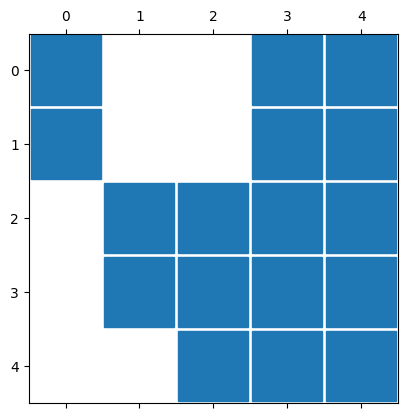

In [14]:
plt.spy(Q1, markersize=50)
plt.show()

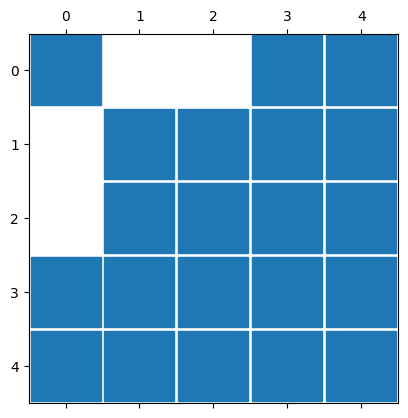

In [15]:
plt.spy(S1, markersize=50)
plt.show()

### Estimate time complexity

In [16]:
sizes = np.logspace(1, 6, num=15, dtype=int)
all_times = []  # store all samples per size

N = 10  # Number of runs per size

for n_leaves in sizes:
    elapsed_times = []
    for _ in range(N):
        t = pcms.tree.cbst(n_leaves, planted=True)
        for i in range(t.n_nodes):
            t.set_edge_length(i, np.random.exponential(t.get_subtree_size(i)))
        
        start = time.time()
        _ = pcms.haar.sparsify(t)
        elapsed = time.time() - start

        elapsed_times.append(elapsed)

    all_times.append(elapsed_times)
    avg_time = np.mean(elapsed_times)
    print(f"n_leaves = {n_leaves:8d} | avg time over {N} runs = {avg_time:.5f} sec")

# Flatten mean for each box for regression
means = [np.mean(times) for times in all_times]

n_leaves =       10 | avg time over 10 runs = 0.00069 sec
n_leaves =       22 | avg time over 10 runs = 0.00046 sec
n_leaves =       51 | avg time over 10 runs = 0.00039 sec
n_leaves =      117 | avg time over 10 runs = 0.00071 sec
n_leaves =      268 | avg time over 10 runs = 0.00069 sec
n_leaves =      610 | avg time over 10 runs = 0.00131 sec
n_leaves =     1389 | avg time over 10 runs = 0.00278 sec
n_leaves =     3162 | avg time over 10 runs = 0.00861 sec
n_leaves =     7196 | avg time over 10 runs = 0.01732 sec
n_leaves =    16378 | avg time over 10 runs = 0.04523 sec
n_leaves =    37275 | avg time over 10 runs = 0.09987 sec
n_leaves =    84834 | avg time over 10 runs = 0.26988 sec
n_leaves =   193069 | avg time over 10 runs = 0.98003 sec
n_leaves =   439397 | avg time over 10 runs = 2.15156 sec
n_leaves =  1000000 | avg time over 10 runs = 5.38935 sec


Approximate empirical time complexity (after burn-in): O(n^1.15)


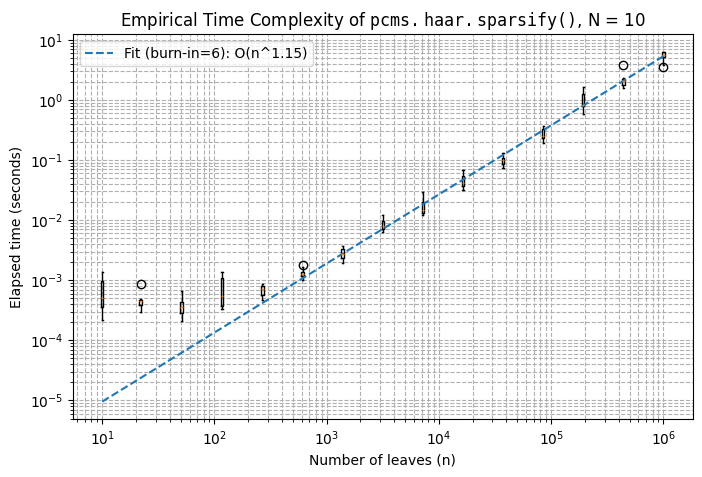

In [17]:
burn_in = 6
sizes_fit = sizes[burn_in:]
means_fit = means[burn_in:]

# Log-log fit on the means
log_sizes = np.log10(sizes_fit)
log_means = np.log10(means_fit)

slope_time, intercept_time, _, _, _ = linregress(log_sizes, log_means)
print(f"Approximate empirical time complexity (after burn-in): O(n^{slope_time:.2f})")

# Best-fit line over full x-axis range for visual
fit_times = 10**(intercept_time + slope_time * np.log10(sizes))

# ---- Box-and-whisker plot ----
plt.figure(figsize=(8, 5))

# Plot boxplot
plt.boxplot(
    all_times, 
    positions=sizes, 
    widths=0.05 * sizes, 
    manage_ticks=False
)

# Best-fit line for mean
plt.loglog(
    sizes, 
    fit_times, 
    '--', 
    color='C0',
    label=f'Fit (burn-in={burn_in}): O(n^{slope_time:.2f})'
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of leaves (n)")
plt.ylabel("Elapsed time (seconds)")
plt.title(r"Empirical Time Complexity of $\mathtt{pcms.haar.sparsify()}$, N = "+str(N))
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Greengenes Tree

In [18]:
t2 = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus_unannotated.nwk'), ensure_planted=True)

In [19]:
edge_lengths = t2.get_edge_length()
eps = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {eps}")

for node in range(t2.n_nodes):
    if t2.get_edge_length(node) == 0:
        t2.set_edge_length(node, eps)

Enforced minimum edge lenght: 0.0001


In [20]:
n = t2.find_n_leaves()
epl = t2.find_epl()

frac = 2 * (epl + 1) / (n * n) - 3 / n
nnz_max = int(np.ceil(frac * n**2))
n_squared = n**2
density = nnz_max / n_squared

print(f"Number of leaves (n): {n}")
print(f"External path length (EPL): {epl}")
print(f"Sparsity bound: {frac:.4%}")
print(f"Max non-zeros (nnz_max): {nnz_max}")
print(f"Dense matrix size: {n_squared}")

Number of leaves (n): 99322
External path length (EPL): 5118645
Sparsity bound: 0.1008%
Max non-zeros (nnz_max): 9939326
Dense matrix size: 9864859684


In [21]:
start = time.time()
Q2, S2 = pcms.haar.sparsify(t2)
print("Elapsed time: ", time.time() - start)

Elapsed time:  0.4392683506011963


In [22]:
print(Q2.shape, Q2.nnz)

(99322, 99322) 5118645


In [23]:
print(S2.shape, S2.nnz)

(99322, 99322) 9931045


In [24]:
def percent_sparsity(matrix):
    return 100 * (1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1]))

print(f"Q sparsity: {percent_sparsity(Q2):.4f}%")
print(f"S sparsity: {percent_sparsity(S2):.4f}%")

Q sparsity: 99.9481%
S sparsity: 99.8993%


In [25]:
print(f"Size of diagonal: {S2.diagonal().size}")
print(f"Number of off-diagonal non-zeros: {S2.nnz - S2.diagonal().size}")

Size of diagonal: 99322
Number of off-diagonal non-zeros: 9831723


In [26]:
def check_csc_rowidx_sorted(matrix: csc_matrix) -> bool:
    """
    Check if the row indices in each column of a CSC sparse matrix are sorted ascending.

    Parameters:
        matrix (csc_matrix): The input CSC sparse matrix.

    Returns:
        bool: True if all columns have sorted row indices, False otherwise.
    """
    indptr = matrix.indptr
    indices = matrix.indices

    for col in range(matrix.shape[1]):
        start = indptr[col]
        end = indptr[col + 1]
        col_indices = indices[start:end]
        if not np.all(col_indices[:-1] <= col_indices[1:]):
            return False
    return True

In [27]:
print(f"Q row indices sorted: {check_csc_rowidx_sorted(Q2)}")
print(f"S row indices sorted: {check_csc_rowidx_sorted(S2)}")

Q row indices sorted: True
S row indices sorted: False


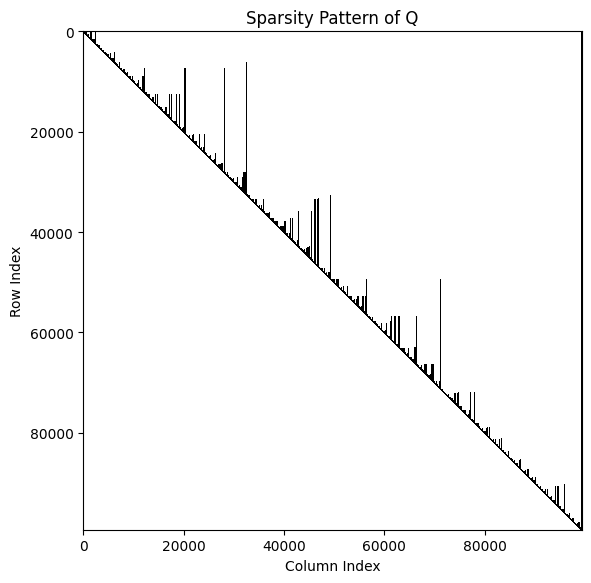

In [28]:
Q2_coo = Q2.tocoo()

fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=Q2_coo.col, y=Q2_coo.row, s=1, edgecolor=None,
                color="black", marker='.', alpha=0.8, ax=ax)

ax.set_aspect('equal', 'box')
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_title("Sparsity Pattern of Q")
ax.set_xlim(0, Q2.shape[1])
ax.set_ylim(Q2.shape[0], 0)  # invert y-axis for matrix-style plot

plt.tight_layout()
plt.show()


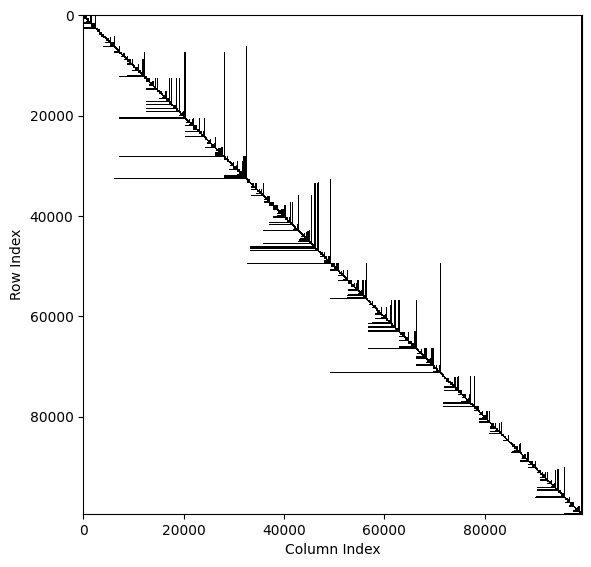

In [29]:
S2_coo = S2.tocoo()

fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=S2_coo.col, y=S2_coo.row, s=1, edgecolor=None,
                color="black", marker='.', alpha=0.8, ax=ax)

ax.set_aspect('equal', 'box')
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
# ax.set_title("Sparsity Pattern of S")
ax.set_xlim(0, S2.shape[1])
ax.set_ylim(S2.shape[0], 0)  # invert y-axis for matrix-style plot

plt.tight_layout()
plt.show()

## The Spectrum of the Phylogenetic Covariance Matrix

### Eigen-Residuals

In [35]:
# Extract diagonal
diag = S2.diagonal()          # 1D array
D_fro = np.linalg.norm(diag)  # Frobenius norm of diagonal

# Off-diagonal part
from scipy.sparse import diags
O = S2 - diags(diag)
O_fro = np.sqrt(O.multiply(O).sum())  # efficient Frobenius norm

# Frobenius ratio
diag_contrib = D_fro / (D_fro + O_fro)
print("Frobenius diag contribution:", diag_contrib)

Frobenius diag contribution: 0.779284463678309


In [51]:
def eigen_residual(i, S, Q):
    col = S.getcol(i)
    col[i, 0] = 0.0
    return Q @ col.toarray().ravel()

def standardized_eigen_residuals(S, Q, diag, N):
    idx = np.argsort(diag)[-N:]
    out = np.empty(N)
    for k, i in enumerate(idx):
        sii = S[i, i]
        out[k] = np.linalg.norm(eigen_residual(i, S, Q)) / abs(sii)
    return idx, out

In [108]:
N = 1000
idx, res = standardized_eigen_residuals(S2, Q2, diag, N)

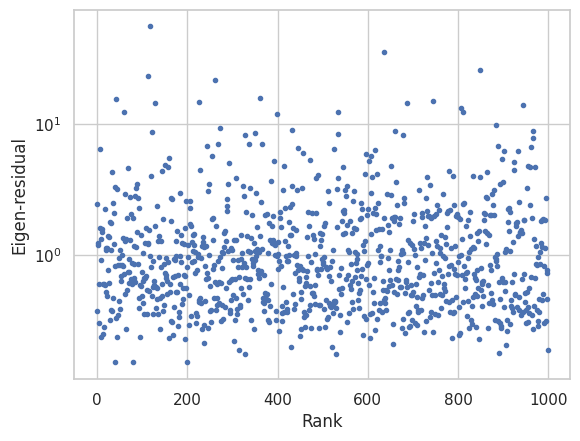

In [109]:
plt.figure()
plt.plot(res, marker=".", linestyle="none")
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Eigen-residual")
plt.show()

### True Spectrum vs. Diagonal

In [30]:
n_eigs = 500

In [31]:
ys = S2.diagonal()
sort = np.argsort(ys)[::-1]
ys = ys[sort][0:n_eigs]
xs = np.arange(ys.size)
ys = np.log10(ys)

In [32]:
lams_ = eigs(S2, k=n_eigs, which='LM')

In [33]:
lams = np.sort(np.abs(lams_[0]))[::-1]
lams = np.log10(lams)

/tmp/ipykernel_47940/1287762746.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


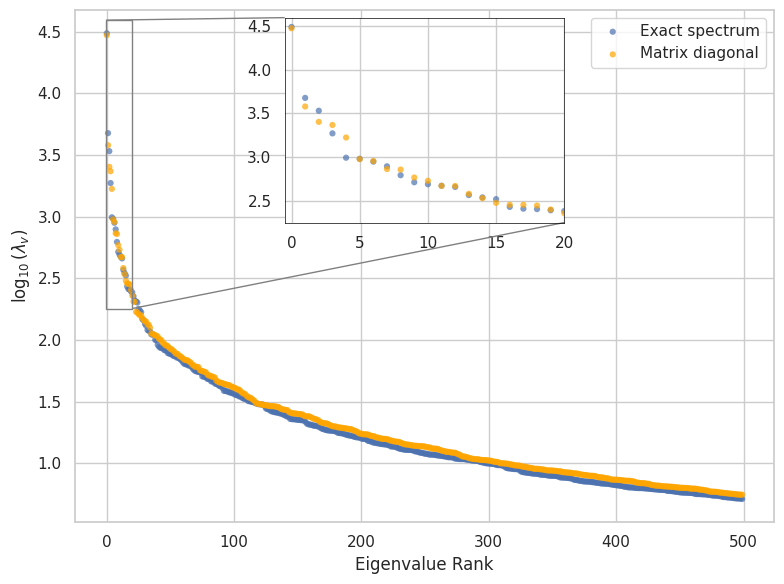

In [34]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter points on main axes
sns.scatterplot(
    x=xs,
    y=lams,
    s=20,
    color='b',
    alpha=0.7,
    edgecolor='none',
    label='Exact spectrum',
    ax=ax
)
sns.scatterplot(
    x=xs,
    y=ys,
    s=20,
    color='orange',
    alpha=0.7,
    edgecolor='none',
    label='Matrix diagonal',
    ax=ax
)

# Create zoom inset axes
axins = inset_axes(ax, width="40%", height="40%", loc='upper center')

# Adjust thickness
for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

# Scatter points on inset axes
sns.scatterplot(
    x=xs, 
    y=lams, 
    s=20, 
    color='b', 
    alpha=0.7, 
    edgecolor='none', 
    ax=axins
)
sns.scatterplot(
    x=xs, 
    y=ys, 
    s=20, 
    color='orange', 
    alpha=0.7, 
    edgecolor='none', 
    ax=axins
)

# Define zoom x-range
x_min, x_max = -0.5, 20
axins.set_xlim(x_min, x_max)

# Select y values corresponding to x in [0,20] for both datasets
mask = (xs >= x_min) & (xs <= x_max)
y_values_in_range = np.concatenate([np.array(lams)[mask], np.array(ys)[mask]])

# Set y limits dynamically with a small padding
padding = 0.05 * (y_values_in_range.max() - y_values_in_range.min())
axins.set_ylim(y_values_in_range.min() - padding, y_values_in_range.max() + padding)

# Draw connecting lines between main plot and inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend(loc='upper right')
ax.set_xlabel('Eigenvalue Rank')
ax.set_ylabel(r'$\log_{10}(\lambda_v)$')

plt.tight_layout()
plt.show()